# Importing required Libraries

In [1]:
import cv2 # OpenCV
import numpy as np # For mathematical operations
from sklearn.decomposition import PCA # For reducing the dimensionality
from scipy.spatial import cKDTree # KD tree data structure for storing features
from scipy.stats import binom # Binomial for calculating the ranking and score
from matplotlib import pyplot as plt # For visualisation and plotting results

# Step:1 Feature Extraction

In [2]:
class FeatureExtractor:
    def __init__(self, n_components = 40):
        '''
        Initialisation function of the FeatureExtractor Class.
        n_components = 40 defaults number of PCA components to reduce the dimensionality
        '''
        self.n_components = n_components
        self.gabor_kernels = self._create_gabor_kernels()

    def _create_gabor_kernels(self):
        '''
        Creates and returns Gabor wavelet filters with different frequencies and orientation.
        Frequency, orientation and scale are the hyper parameters.
        They need to changed according to the dataset.
        '''
        gabor_kernels = [] # list of all the kernels
        frequencies = [0.1, 0.2, 0.4, 0.8]
        orientations = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
        for freq in frequencies:
            for theta in orientations:
                # creating gabor kernel each with scale 1.5
                kernel = cv2.getGaborKernel((21, 21), 1.5, theta, freq, 1.0, 0, cv2.CV_32F) 
                gabor_kernels.append(kernel)
        return gabor_kernels

    def extract_features(self, image):
        '''
        It converts the colour image to gray image.
        This function extract the features using Gabor wavelet and
        Laplacian of Gaussian on the input. 
        It plots and returns the extracted features.
        '''
        # convert BGR image to Gray
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features = [] # list which save all the features
        for kernel in self.gabor_kernels:
            # apply gabor kernel on the gray image
            filtered_image = cv2.filter2D(gray_image, cv2.CV_8UC3, kernel)
            # apply the Laplacian on the Gabor response
            laplacian_response = cv2.Laplacian(filtered_image, cv2.CV_64F)
            #features.append(laplacian_response.mean())
            features.append(laplacian_response)
            
            plt.subplot(121)
            # Response from Gabor wavelet
            plt.imshow(filtered_image, cmap='gray')
            plt.subplot(122)
            # After applying Laplacian of Gaussian
            plt.imshow(laplacian_response, cmap='gray')
            plt.show()
        # Convert list of features to numpy array
        features = np.array(features)
        return features
    
    def fit_pca(self, template_features):
        '''
        Fitting the Principal Component Analysis (PCA) on the template features.
        '''
        self.pca = PCA(n_components = self.n_components)
        print(template_features.shape)
        compressed_features = self.pca.fit_transform(template_features)
        return compressed_features

    def transform_feature(self, feature):
        '''
        Applying PCA on the query image.
        In other words, applying the fitted PCA model on query image.
        '''
        compressed_feature = self.pca.transform(feature)
        return compressed_feature.flatten()

# Step:2 Index Builder

In [7]:
class IndexBuilder:
    def __init__(self, features):
        '''
        Initialisation method for IndexBuilder class.
        Takes features as an input.
        '''
        self.features = features
        self.kd_tree = self._build_kd_tree(features)

    def _build_kd_tree(self, features):
        '''
        This method builds the KD tree with the input features and returns the KD tree.
        '''
        reshaped_features = features.reshape(features.shape[0], -1)
        return cKDTree(reshaped_features)

    def search(self, query_features):
        '''
        This method searches for the query features given as an input into the KD tree.
        It returns the distance and the indices of the matched features
        '''
        m,n,o = query_features.shape
        reshaped_query_features = np.reshape(query_features,(m,n*o))
        distances, indices = self.kd_tree.query(reshaped_query_features, k=3)
        return distances.flatten(), indices.flatten()

    def prune_common_patterns(self):
        '''
        This method is under construction right now.
        It helps to prune the KD tree or features by eliminatin the
        common features found between template images.
        '''
        matches = [] # list of matched features
        for i, template_features in enumerate(self.features):
            # uses _match_features to find the indices of the common features
            indices = self._match_features(template_features)
            matches.append(indices)

        # Removing the common features
        remove_indices = np.concatenate(matches, axis=0)
        remove_indices = np.unique(remove_indices)

        mask = np.ones(self.features.shape[0], dtype=bool)
        mask[remove_indices] = False

        # Rebuild the KD tree with new features
        self.features = self.features[mask]
        self.kd_tree = self._build_kd_tree(self.features)

    def _match_features(self, features):
        '''
        This method uses Euclidean distances to find the closest common features.
        It returns the indices of the top 3 matched features.
        '''
        distances = np.linalg.norm(self.features - features, axis=0)  # Calculate L2-norm distance
        indices = np.argsort(distances)[:3]  # Top 3 closest matches
        return indices

# Step:3 Feature Matching

In [5]:
class FeatureMatcher:
    def __init__(self, index_builder):
        '''
        Initialisation method of the FeatureMatcher class.
        Takes index builder object as an input.
        '''
        self.index_builder = index_builder

    def match_features(self, query_feature):
        '''
        It searches for the query_features given as an input into the built index.
        It uses the index builder's class object and it's search method to get
        the closest distant features and it's indices.
        It returns the distance and index.
        '''
        dist, idx = self.index_builder.search(query_feature)
        return dist, idx

# Step:4 Spatial Matching

In [6]:
class SpatialMatcher:
    def __init__(self):
        '''
        Initialisation method for the SpatialMatcher class.
        It initialises the Brute Force Matcher.
        Refer: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
        We will use it which SIFT Descriptors
        '''
        self.matcher = cv2.BFMatcher()

    def match_features(self, descriptors1, descriptors2):
        '''
        It matches the two descriptors given as input and find 2 best nearest neighbours.
        The one decriptors is from the template image and the other from the query image.
        It returns the list of good matches.
        '''
        matches = self.matcher.knnMatch(descriptors1, descriptors2, k=2)
        good_matches = [] # list of good matches
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        return good_matches

# Step:5 Ranking

In [8]:
class MatcherScorer:
    def __init__(self):
        '''
        Initialisation method for the MatcherScorer class.
        It declares the prior_probability variable.
        '''
        self.prior_probability = None

    def compute_prior_probability(self, num_template_features, num_query_features, num_index_features):
        '''
        It computes the prior probability and returns it.
        '''
        p = (num_template_features * num_query_features) / num_index_features
        return p

    def compute_cluster_probability(self, k, n, p):
        '''
        k - length of the cluster
        n - total number of template features
        p - total number of features indices
        The probability that a cluster
        having k features gets matched by chance to the template
        image out of n features can be estimated by the
        cumulative binomial distribution
        '''
        cluster_prob = binom.cdf(k, n, p)
        return cluster_prob

    def compute_score(self, clusters, num_template_features, num_index_features):
        '''
        The final score of a matched template is then the
        maximum probability that a cluster is not matched by
        chance among all the matched clusters to this template.
        That is stored to the max_prob variable.
        '''
        scores = [] # List of scores
        for cluster in clusters:
            n = len(cluster)
            p = self.compute_prior_probability(num_template_features, n, num_index_features)
            max_prob = np.max(1 - self.compute_cluster_probability(n, num_template_features, p))
            scores.append(max_prob)
        return scores

# Example usage

In [3]:
image_path = 'input.jpg' # change path to the input image
image = cv2.imread(image_path) # OpenCV reads image in BGR format instead of standard RGB
image = cv2.resize(image, (224,224)) # resize the image

In [4]:
query_image_path = 'query.jpg' # change path to the query image
query_image = cv2.imread(query_image_path) # OpenCV reads image in BGR format instead of standard RGB
query_image = cv2.resize(query_image, (224,224)) # resize the image

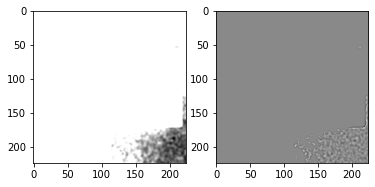

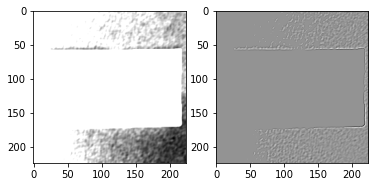

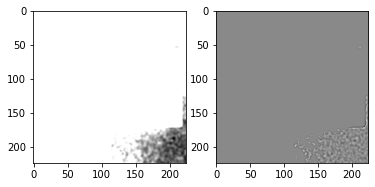

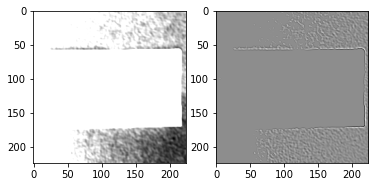

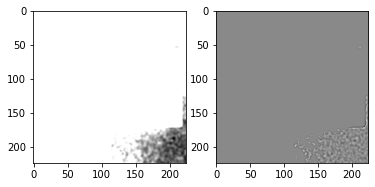

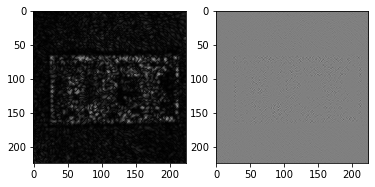

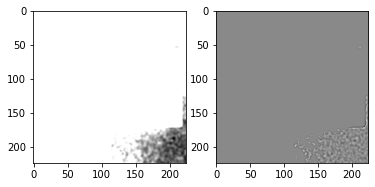

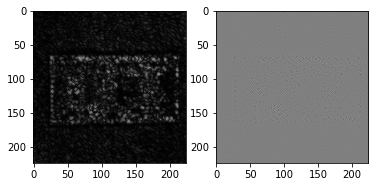

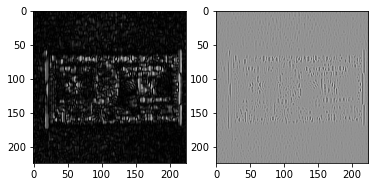

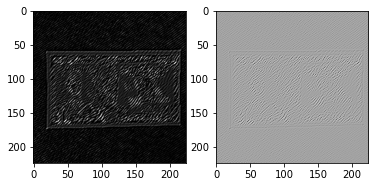

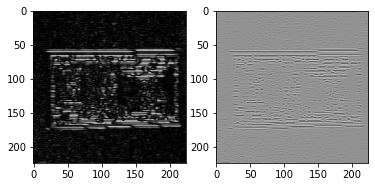

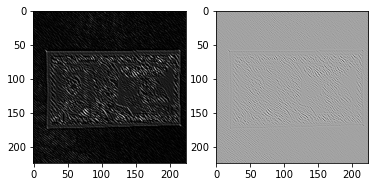

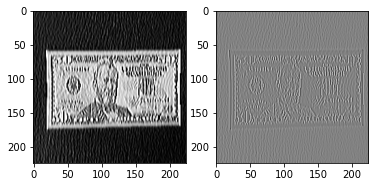

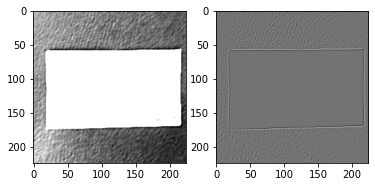

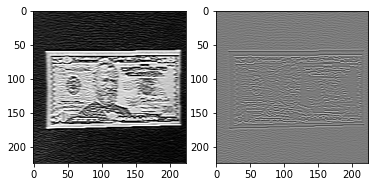

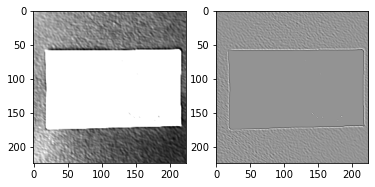

In [9]:
# Assuming you have template_images and query_image

# Feature extraction
extractor = FeatureExtractor()
template_features = extractor.extract_features(image)
# np.array([extractor.extract_features(template_image) for template_image in image])

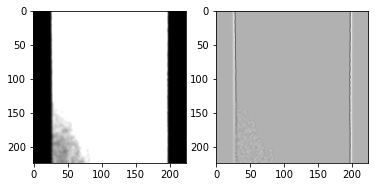

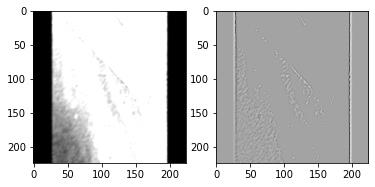

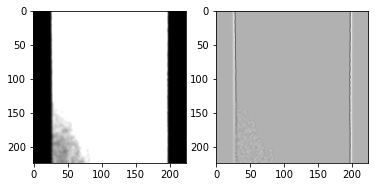

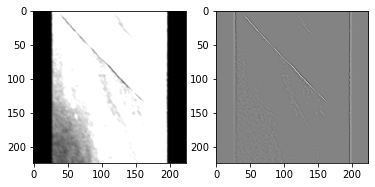

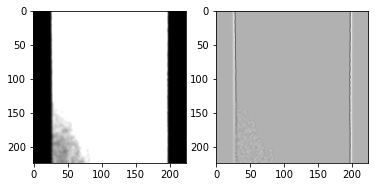

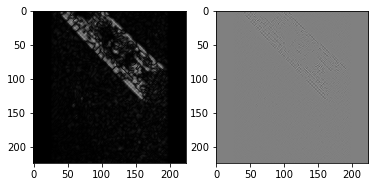

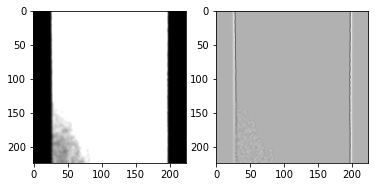

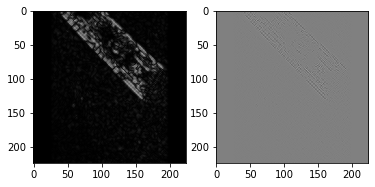

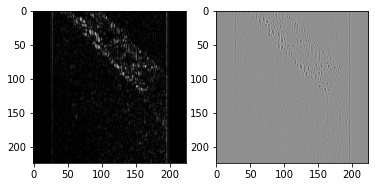

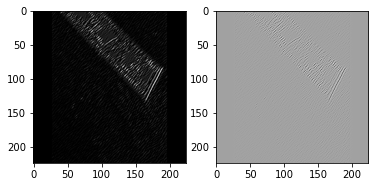

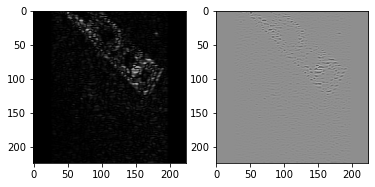

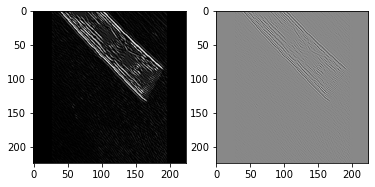

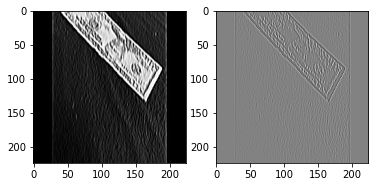

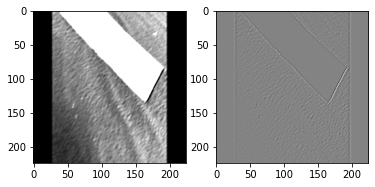

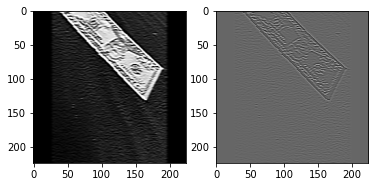

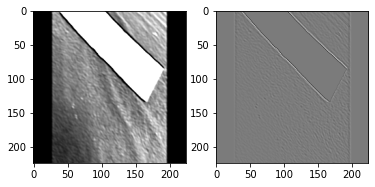

In [10]:
query_features = extractor.extract_features(query_image)

In [11]:
# Index building
temp_index_builder = IndexBuilder(template_features)
query_index_builder = IndexBuilder(query_features)

In [12]:
# Feature matching
matcher = FeatureMatcher(temp_index_builder)
distances, indices = matcher.match_features(query_features)

# Applying SIFT

In [13]:
# Extract keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(image, None)
keypoints2, descriptors2 = sift.detectAndCompute(query_image, None)

In [14]:
# Apply spatial matching using SIFT keypoints
spatial_matcher = SpatialMatcher()
good_matches = spatial_matcher.match_features(descriptors1, descriptors2)

In [15]:
# Scoring and ranking
matcher_scorer = MatcherScorer()
num_template_features = len(keypoints2)
num_index_features = len(keypoints1)
clusters = [[m.trainIdx for m in good_matches]]
scores = matcher_scorer.compute_score(clusters, num_template_features, num_index_features)

In [16]:
# Sort matches based on scores
sorted_matches = [good_matches[i] for i in np.argsort(scores)[::-1]]

# Draw matches or Results

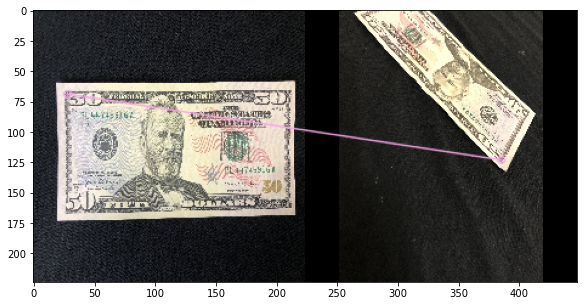

In [18]:
matching_result = cv2.drawMatches(image, keypoints1, query_image, keypoints2, sorted_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display results
plt.figure(figsize=(15,5))
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
plt.show()